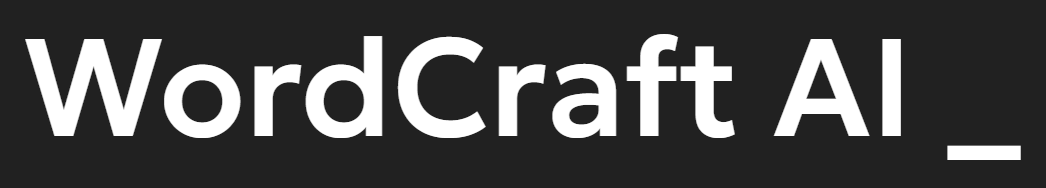

## Импорт библиотек

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from datetime import datetime
import json

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import plot_model
from keras.models import load_model

from sklearn.model_selection import train_test_split

## Загрузка датасета

In [4]:
def load_dataset(csv_file_path):
  df = pd.read_csv(csv_file_path, header=0, sep = "\t")
  words_column = df.iloc[:, 0]
  words = [word.lower() for word in words_column.tolist()]

  return words

In [5]:
csv_file_path = 'nouns.csv'
dataset = load_dataset(csv_file_path)

print(dataset[:10])
print(len(dataset))

['человек', 'год', 'время', 'рука', 'стать', 'дело', 'раз', 'глаз', 'день', 'жизнь']
26982


## Анализ датасета

In [6]:
df = pd.DataFrame({'word': dataset})
df['word_length'] = df['word'].apply(len)
df

,word,word_length
0,человек,7
1,год,3
2,время,5
3,рука,4
4,стать,5
...,...,...
26977,ссыкуха,7
26978,туроператор,11
26979,валенок,7
26980,бабло,5


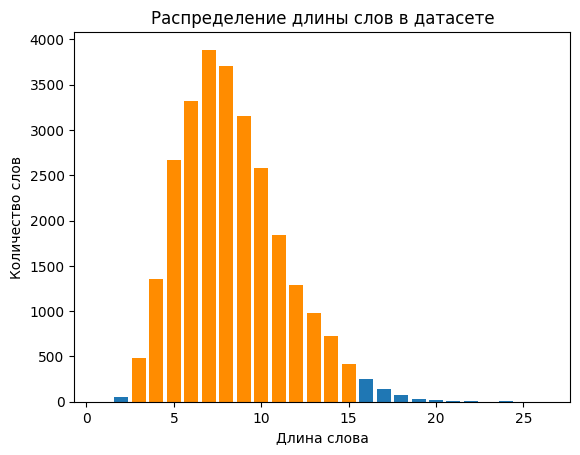

In [7]:
plt.hist(df['word_length'], bins=range(1, max(df['word_length']) + 2), align='left', rwidth=0.8)
plt.hist(df['word_length'][(df['word_length'] >= 3) & (df['word_length'] <= 15)], bins=range(1, max(df['word_length']) + 2), align='left', rwidth=0.8, color='darkorange')
plt.xlabel('Длина слова')
plt.ylabel('Количество слов')
plt.title('Распределение длины слов в датасете')
plt.show()

In [6]:
df[df['word_length'] < 3]['word']

25       уж
209      ум
318      ах
741      ус
888      юг
894      цк
1541     ад
1807     яд
2048     па
2121     ир
2715     си
3097     щи
3150     ти
3374     як
4010     ил
4162     кп
4214     ёж
4346     му
4414     пи
5125     ас
5327     яр
5666     ре
5715     ук
5856     аз
6429     ар
6500     цб
6951     эн
7212     кб
7282     ша
9196     эс
10199    ош
10390    эл
11241    гб
11281    эм
11663    зи
11839    ют
12452    вт
13037    яс
13772    фа
14366    бд
14523    го
14604    ор
14605    че
14645    ка
14717    ер
14910    ом
26307    ст
26399    ям
Name: word, dtype: object

In [7]:
df[df['word_length'] > 20]['word']

6792          достопримечательность
9117       высокопревосходительство
10804         конкурентоспособность
13917         самосовершенствование
16168         взаимообусловленность
17872      инженер-кораблестроитель
19356         металлопромышленность
19898        недисциплинированность
20074        непредусмотрительность
20164        неудовлетворительность
20973         библиотека-передвижка
21006       переосвидетельствование
22766         светочувствительность
23107         слесарь-водопроводчик
23303        социалист-революционер
24453        генерал-губернаторство
24703    истребитель-бомбардировщик
24704       истребитель-перехватчик
26260      человеконенавистничество
Name: word, dtype: object

In [8]:
duplicate_counts = df['word'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
duplicate_counts

мётчик            3
венец             2
отступничество    2
апокриф           2
премирование      2
                 ..
мастерок          2
рэгги             2
скорбут           2
басма             2
острожник         2
Name: word, Length: 123, dtype: int64

## Фильтрация датасета

In [17]:
min_word_length = 3
max_word_length = 15

In [11]:
def filter_dataset(dataset, min_length, max_length):
  russian_alphabet_pattern = re.compile('[а-яё]+')
  unique_words = set()

  for word in dataset:
    if min_length <= len(word) <= max_length and russian_alphabet_pattern.fullmatch(word) and word not in unique_words:
      unique_words.add(word)

  return list(unique_words)

In [12]:
dataset = filter_dataset(dataset, min_word_length, max_word_length)

len(dataset)

26084

## Подготовка данных для модели

In [13]:
alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'

In [14]:
# Создает one-hot вектор для символа
def char_to_one_hot(char):
  one_hot_vector = np.zeros(len(alphabet), dtype=int)
  if char in alphabet:
    one_hot_vector[alphabet.index(char)] = 1

  return one_hot_vector.tolist()

In [15]:
# Создает матричное представление для слова
def word_to_vector(word):
  padded_word = word.ljust(max_word_length, ' ')

  return [char_to_one_hot(char) for char in padded_word]

In [16]:
# Генерирует случайную строку
def generate_fake_word(min_length, max_length):
  length = random.randint(min_length, max_length)
  fake_word = ''.join(random.choice(alphabet) for _ in range(length))

  return fake_word

In [22]:
fake_words = [generate_fake_word(min_word_length, max_word_length) for _ in range(len(dataset))]

print(fake_words[0])
print(len(fake_words))

ппюдгэ
26084


In [23]:
X_data = [word_to_vector(word) for word in dataset + fake_words]
y_data = [1] * len(dataset) + [0] * len(fake_words)

len(X_data)

52168

In [24]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

In [25]:
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

## Создание модели классификатора

In [106]:
# Создание модели
model = Sequential()
model.add(LSTM(64, input_shape=(max_word_length, len(alphabet))))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

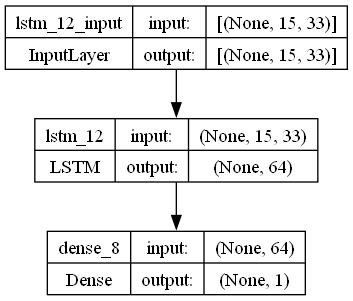

In [30]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Обучение модели

In [108]:
# Обучение модели
history = model.fit(X_train_array, y_train_array, epochs=15, batch_size=32, validation_data=(X_test_array, y_test_array))

current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
model.save(f'classifier_{current_datetime}.keras', overwrite=True)

Epoch 1/15
1305/1305 [==============================] - 5s 3ms/step - loss: 0.1821 - accuracy: 0.9251 - val_loss: 0.1424 - val_accuracy: 0.9428
Epoch 2/15
1305/1305 [==============================] - 4s 3ms/step - loss: 0.1228 - accuracy: 0.9511 - val_loss: 0.1110 - val_accuracy: 0.9577
Epoch 3/15
1305/1305 [==============================] - 4s 3ms/step - loss: 0.0935 - accuracy: 0.9640 - val_loss: 0.0794 - val_accuracy: 0.9692
Epoch 4/15
1305/1305 [==============================] - 4s 3ms/step - loss: 0.0770 - accuracy: 0.9710 - val_loss: 0.0834 - val_accuracy: 0.9681
Epoch 5/15
1305/1305 [==============================] - 4s 3ms/step - loss: 0.0698 - accuracy: 0.9731 - val_loss: 0.0721 - val_accuracy: 0.9694
Epoch 6/15
1305/1305 [==============================] - 4s 3ms/step - loss: 0.0660 - accuracy: 0.9751 - val_loss: 0.0683 - val_accuracy: 0.9728
Epoch 7/15
1305/1305 [==============================] - 4s 3ms/step - loss: 0.0605 - accuracy: 0.9770 - val_loss: 0.0622 - val_accuracy:

## Оценка модели

In [109]:
accuracy = model.evaluate(X_test_array, y_test_array)[1]
print(f'Точность модели на тестовых данных: {accuracy}')

327/327 [==============================] - 0s 1ms/step - loss: 0.0592 - accuracy: 0.9785
Точность модели на тестовых данных: 0.9785317182540894


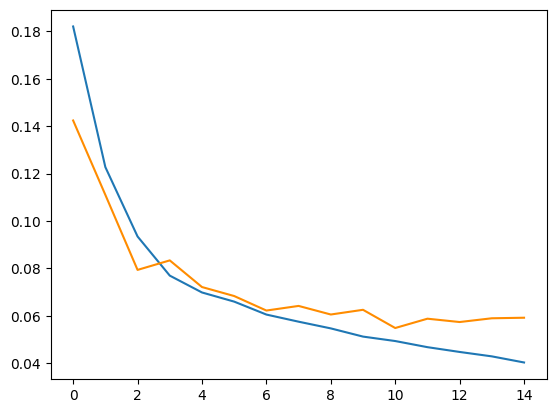

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='darkorange')

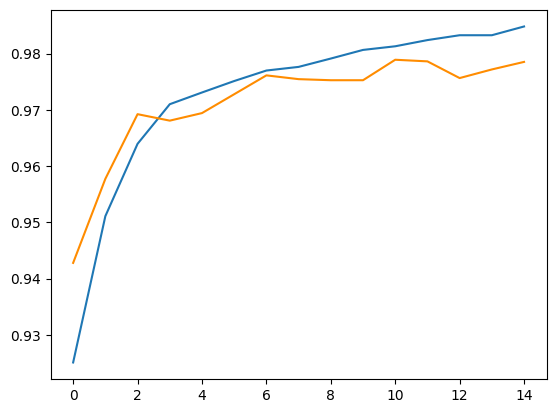

In [111]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='darkorange')

## Тестирование

In [9]:
loaded_model = load_model('classifier_20231206_125853.keras')

In [18]:
def get_predictions(words_to_predict):
  words_to_predict_vectors = [word_to_vector(word) for word in words_to_predict]
  predictions = loaded_model.predict(np.array(words_to_predict_vectors))

  return [prediction[0] for prediction in predictions]

In [19]:
def print_prediction(words_to_predict):
  predictions = get_predictions(words_to_predict)
  for word, prediction in zip(words_to_predict, predictions):
    print(f'{word}: {prediction}')

In [21]:
fake_words_to_predict = [generate_fake_word(min_word_length, max_word_length) for _ in range(4)]
print('Сгенерированные случайные наборы символов')
print_prediction(fake_words_to_predict)

real_words_to_predict = ['слово', 'телефон', 'интеллект', 'подушка']
print('\nРеальные слова')
print_prediction(real_words_to_predict)

input_words_to_predict = ['абвгд', 'щзорпа', 'опрвра', 'вапгшри']
print('\nСлучайные наборы символов, набранные вручную')
print_prediction(input_words_to_predict)

input_words_to_predict = ['атомия', 'активаст', 'амбия', 'гадан']
print('\n"Слова", сгенерированные прототипом генератора')
print_prediction(input_words_to_predict)

Сгенерированные случайные наборы символов
1/1 [==============================] - 0s 14ms/step
слсъе: 0.00038954985211603343
гюш: 0.02477315627038479
чфярм: 0.0065804822370409966
мявлътюнбнюъэуй: 1.5261946828104556e-05

Реальные слова
1/1 [==============================] - 0s 15ms/step
слово: 0.9945042729377747
телефон: 0.9995988607406616
интеллект: 0.9999576807022095
подушка: 0.9999693036079407

Случайные наборы символов, набранные вручную
1/1 [==============================] - 0s 13ms/step
абвгд: 0.011696855537593365
щзорпа: 0.0020396022591739893
опрвра: 0.03891933709383011
вапгшри: 0.0025370039511471987

"Слова", сгенерированные прототипом генератора
1/1 [==============================] - 0s 15ms/step
атомия: 0.9969674944877625
активаст: 0.9999436140060425
амбия: 0.9003759026527405
гадан: 0.9913632869720459


## Оценка результатов генератора

In [22]:
json_file_path = "generator_result.json"

with open(json_file_path, "r", encoding="utf-8") as json_file:
    generator_data = json.load(json_file)

In [23]:
generator_results = [entry['Result'] for entry in generator_data]

In [24]:
predictions_for_generator = get_predictions(generator_results)

103/103 [==============================] - 0s 1ms/step


In [136]:
data = []

for entry, prediction in zip(generator_data, predictions_for_generator):
  new_entry = {"Input": entry['Input'], "Output": entry['Output'], "Result": entry['Result'], "Value": float(prediction)}
  data.append(new_entry)

with open("classifier_result.json", "w", encoding="utf-8") as json_file:
  json.dump(data, json_file, ensure_ascii=False, indent=2)

In [25]:
filtered_data = []

for entry, prediction in zip(generator_data, predictions_for_generator):
  if prediction >= 0.9:
    new_entry = {"Input": entry['Input'], "Output": entry['Output'], "Result": entry['Result'], "Value": float(prediction)}
    filtered_data.append(new_entry)

with open("classifier_filtered_result.json", "w", encoding="utf-8") as json_file:
    json.dump(filtered_data, json_file, ensure_ascii=False, indent=2)